In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


### Load data from previous step

In [2]:
df = pd.read_csv('df_balanced_with_new_features.csv',
                 converters={'id': str, 
                             'member_id': str})
df.head()

,id,member_id,loan_amnt,emp_length,home_ownership,annual_inc,desc,purpose,dti,inq_last_6mths,...,loan_amnt_log,annual_inc_log,total_bc_limit_log,tot_hi_cred_lim_log,tot_cur_bal_log,emp_length_encoded,home_ownership_encoded,purpose_encoded,bc_util_fixed_X_revol_util_nb_fixed,annual_inc_binned
0,10000001,11983056,7550,3 years,RENT,28000.0,NaN,debt_consolidation,8.40,0.0,...,8.929303,10.239960,8.294050,8.250347,8.658519,3,4,2,921600.0,1.0
1,10000002,12002921,27050,10+ years,OWN,55000.0,Borrower added on 12/31/13 > Combining high ...,debt_consolidation,22.87,0.0,...,10.205442,10.915088,10.482906,10.444647,11.651243,1,3,2,290521.0,2.0
2,10000003,11983096,12000,4 years,RENT,60000.0,Borrower added on 12/31/13 > I would like to...,debt_consolidation,4.62,1.0,...,9.392662,11.002100,9.803667,9.706049,8.873048,4,4,2,25281.0,3.0
3,10000004,12003142,28000,5 years,MORTGAGE,325000.0,NaN,debt_consolidation,18.55,1.0,...,10.239960,12.691580,10.650176,10.545714,13.591857,5,0,2,450241.0,4.0
4,10000005,11993233,12000,10+ years,RENT,40000.0,NaN,debt_consolidation,16.94,0.0,...,9.392662,10.596635,8.853665,8.775157,9.518193,1,4,2,633616.0,1.0


### 3. Model Development

#### 3.1 Use LASSO to select variables

In [3]:
from sklearn.linear_model import Lasso
x_vars = ['loan_amnt', 'annual_inc', 'dti', 'inq_last_6mths', 'internal_score',
        'term_nb', 'int_rate_nb', 'percent_bc_gt_75',
       'bc_util_fixed', 'mths_since_recent_inq', 'total_bc_limit',
       'mths_since_last_major_derog', 'tot_hi_cred_lim', 'tot_cur_bal',
       'revol_util_nb_fixed', 'loan_amnt_log', 'annual_inc_log',
       'total_bc_limit_log', 'tot_hi_cred_lim_log', 'tot_cur_bal_log',
       'emp_length_encoded', 'home_ownership_encoded', 'purpose_encoded', 'bc_util_fixed_X_revol_util_nb_fixed', 'annual_inc_binned']
X_train, X_test, y_train, y_test = train_test_split(df[x_vars], df['bad_flag'], train_size=0.8, random_state=42)
# Initialize and fit the Lasso model
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

# Get the coefficients of the features
lasso_coefficients = pd.Series(lasso.coef_, index=X_train.columns)

# Select the variables with non-zero coefficients
selected_variables = lasso_coefficients[lasso_coefficients != 0].index.tolist()

print("Selected variables:", selected_variables)

Selected variables: ['loan_amnt', 'annual_inc', 'dti', 'term_nb', 'percent_bc_gt_75', 'mths_since_recent_inq', 'total_bc_limit', 'tot_hi_cred_lim', 'tot_cur_bal', 'revol_util_nb_fixed', 'purpose_encoded', 'bc_util_fixed_X_revol_util_nb_fixed']


#### 3.2 Keep only selected variables and convert Pandas DataFrame to Tensor

In [4]:
X_raw = torch.from_numpy(df[selected_variables].values).type(torch.float32)
y = torch.from_numpy(df['bad_flag'].values).type(torch.float32)

#### 3.3 Standardization 

In [5]:
means = X_raw.mean(dim=0)
stds = X_raw.std(dim=0)

X_std = (X_raw - means) / stds
X_std.shape, y.shape

(torch.Size([352223, 12]), torch.Size([352223]))

#### 3.4 Split train / test datasets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, train_size=0.8, random_state=42)
print("\nTraining data:")
print(X_train.shape, y_train.shape)
    
print("\nTest data:")
print(X_test.shape, y_test.shape)


Training data:
torch.Size([281778, 12]) torch.Size([281778])

Test data:
torch.Size([70445, 12]) torch.Size([70445])


#### 3.5 Create a model instant

In [30]:

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

in_f = X_train.shape[1]

# LoanModel = nn.Sequential(
#     nn.Linear(in_features=in_f, out_features=neurions_L1),
#     nn.Linear(in_features=neurions_L1, out_features=1), 
#     nn.ReLU()
# ).to(device)

class Net(nn.Module):
    def __init__(self, in_f):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=in_f, out_features=100)
        self.layer_2 = nn.Linear(in_features=100, out_features=1)
        # self.layer_3 = nn.Linear(in_features=200, out_features=1)
        # self.layer_4 = nn.Linear(in_features=400, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.relu(self.layer_2(self.relu(self.layer_1(x))))

LoanModel = Net(in_f).to(device)


#### 3.6 Define loss function, optimizer and accuracy-checking function

In [31]:
# Create a loss function
loss_fn = nn.BCELoss() 

# Create an optimizer
optimizer = torch.optim.SGD(params=LoanModel.parameters(), 
                            lr=0.2)

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

#### 3.7 Train the model in the loop

In [32]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

loss_list = []
# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    LoanModel.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = LoanModel(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    loss = loss_fn(torch.sigmoid(y_logits), 
                   y_train) 
    loss_list.append(loss.item())
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    LoanModel.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = LoanModel(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(torch.sigmoid(test_logits),
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70316, Accuracy: 45.86% | Test loss: 0.69806, Test acc: 46.86%
Epoch: 100 | Loss: 0.68228, Accuracy: 57.96% | Test loss: 0.68297, Test acc: 57.88%
Epoch: 200 | Loss: 0.67963, Accuracy: 58.89% | Test loss: 0.68069, Test acc: 58.62%
Epoch: 300 | Loss: 0.67876, Accuracy: 59.14% | Test loss: 0.67994, Test acc: 58.78%
Epoch: 400 | Loss: 0.67816, Accuracy: 59.21% | Test loss: 0.67937, Test acc: 58.78%
Epoch: 500 | Loss: 0.67765, Accuracy: 59.29% | Test loss: 0.67888, Test acc: 58.96%
Epoch: 600 | Loss: 0.67726, Accuracy: 59.42% | Test loss: 0.67852, Test acc: 59.05%
Epoch: 700 | Loss: 0.67693, Accuracy: 59.54% | Test loss: 0.67819, Test acc: 59.19%
Epoch: 800 | Loss: 0.67659, Accuracy: 59.68% | Test loss: 0.67785, Test acc: 59.42%
Epoch: 900 | Loss: 0.67622, Accuracy: 59.75% | Test loss: 0.67745, Test acc: 59.50%


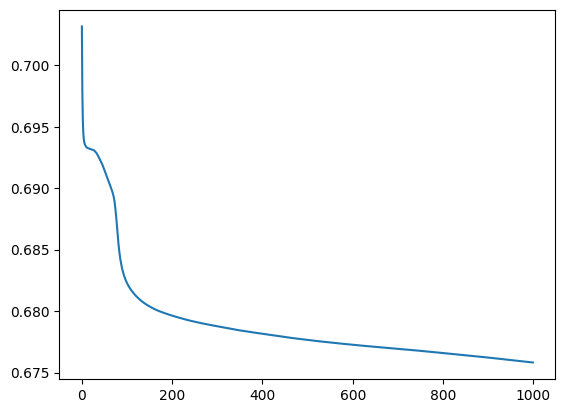

In [33]:
plt.plot(loss_list)

### 4. Save the trained model

In [34]:
torch.save(LoanModel.state_dict(), 'trained_loan_model_v0122.pth')